# YOLOv8n Vessel Detection Model Evaluation

## 1. Setup

In [11]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Set up data paths
from pathlib import Path
import sys

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))
sys.path.append("/home/peterm/UWA/CITS5014/SARFish/working")

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR:     {DATA_DIR}")
print(f"CONFIG_DIR:   {CONFIG_DIR}")
print(f"RUNS_DIR:     {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR:   /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [13]:
%matplotlib inline
import numpy as np
import yaml
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO
from utilities import *
from plot_loss_curves import plot_total_loss
from du_utilities import *
from compare_validation_predictions import create_sar_prediction_comparison

## 2. Vessel detection model evaluation on test data

The original 96 x 96 pixel training dataset was augmented as a way of addressing the problem of class imbalance in the data. Several geometric transforms (horizontal flip, vertical flip, 90, 180 and 270 degree anti-clockwise rotation and translation) were applied to the image crops in varying combination. In addition, composite images or 'mosaics' were  generated to expand the dataset even further. Augmentation was applied to the raw image crops prior to processing. The best performing pretrained YOLOv8n model configuration used to train the augmented and processed dataset is shown below. Note that 'in situ' augmentation or augmentation while training, was also applied.

### 2.1 Set up model paths

The yaml file below describes the data sources usd to train the best model (Run# 20250818_1835)

In [14]:
# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
print(data)

{'names': ['is_vessel', 'is_fishing'], 'nc': 2, 'path': '/home/peterm/UWA/CITS5014/SARFish/modelling/data', 'test': 'test_alt', 'train': 'train_hvrt_msc_bal_alt', 'val': 'val_alt'}


In [15]:
# Define the path to the best model for retrieval
results_path = RUNS_DIR / 'png_runs' / 'png_aug_bal' / '20250818_1835'

In [16]:
# Define the path to the best model
model_path=results_path / 'weights' / 'best.pt'
print(model_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250818_1835/weights/best.pt


### 2.2 Evalute model on the test set:

In [17]:
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
eval_path = results_path / "evaluation"
print(yaml_path)
print(eval_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250818_1835/evaluation


In [18]:
# Load the model
model = YOLO(model_path)

# Run validation with Ultralytics defaults
test_results = model.val(
    data=yaml_path,  # data.yaml file from training
    project=eval_path,
    split='test',
    conf=0.25,       # default Ultralytics validation!
    iou=0.7,         # Default IoU threshold for NMS
    plots=True,
    verbose=True
)

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2316.3±740.9 MB/s, size: 20.3 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/test_alt/labels.cache... 253 images, 0 backgrounds, 0 cor
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<


                   all        253        253      0.547      0.632      0.554      0.279
             is_vessel        221        221      0.747      0.733      0.785      0.416
            is_fishing         32         32      0.347      0.531      0.324      0.142
Speed: 0.9ms preprocess, 4.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250818_1835/evaluation/val


In [25]:
df = test_results.to_df()
df  # DO NOT USE - last three columns are wrong!

,class_name,box-p,box-r,box-f1,box-map,box-map50,box-map75
0,is_vessel,0.74654,0.73303,0.73973,0.27902,0.55438,0.24956
1,is_fishing,0.34694,0.53125,0.41975,0.27902,0.55438,0.24956


In [1]:
# WIll need to manually extract F1-score using this formula
f1_formula = "F1 = 2 * (Precision * Recall) / (Precision + Recall)"
print(f1_formula) 

F1 = 2 * (Precision * Recall) / (Precision + Recall)


In [2]:
2 * (0.747 * 0.733) / (0.747 + 0.733)

0.7399337837837838

### 2.3 Confusion Matrix

In [19]:
# Print the un-normalised confusion matrix
print(test_results.confusion_matrix.to_df())

    Predicted  is_vessel  is_fishing  background
0   is_vessel      166.0         9.0        42.0
1  is_fishing       20.0        18.0        11.0
2  background       35.0         5.0         0.0


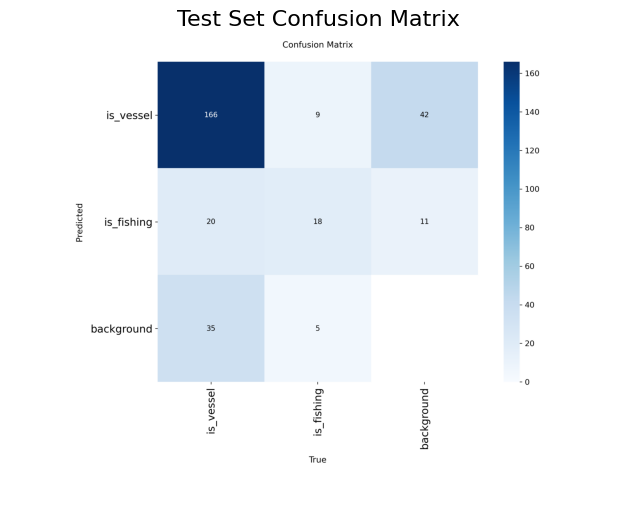

In [20]:
# Load and display the confusion matrix
img_path = eval_path / 'val' / 'confusion_matrix.png'
img = mpimg.imread(img_path)

plt.figure(figsize=(8, 6))  # Width x Height in inches
plt.imshow(img)
plt.axis('off')  # Optional: hides axis ticks
plt.title('Test Set Confusion Matrix', fontsize=16)
plt.show()

### 2.4 Visualisation: test predictions vs ground truth

In [14]:
# Specify test image directory
test_images_path = DATA_DIR / "test_alt" / "images"

Found 253 images. Displaying 6 randomly selected images:



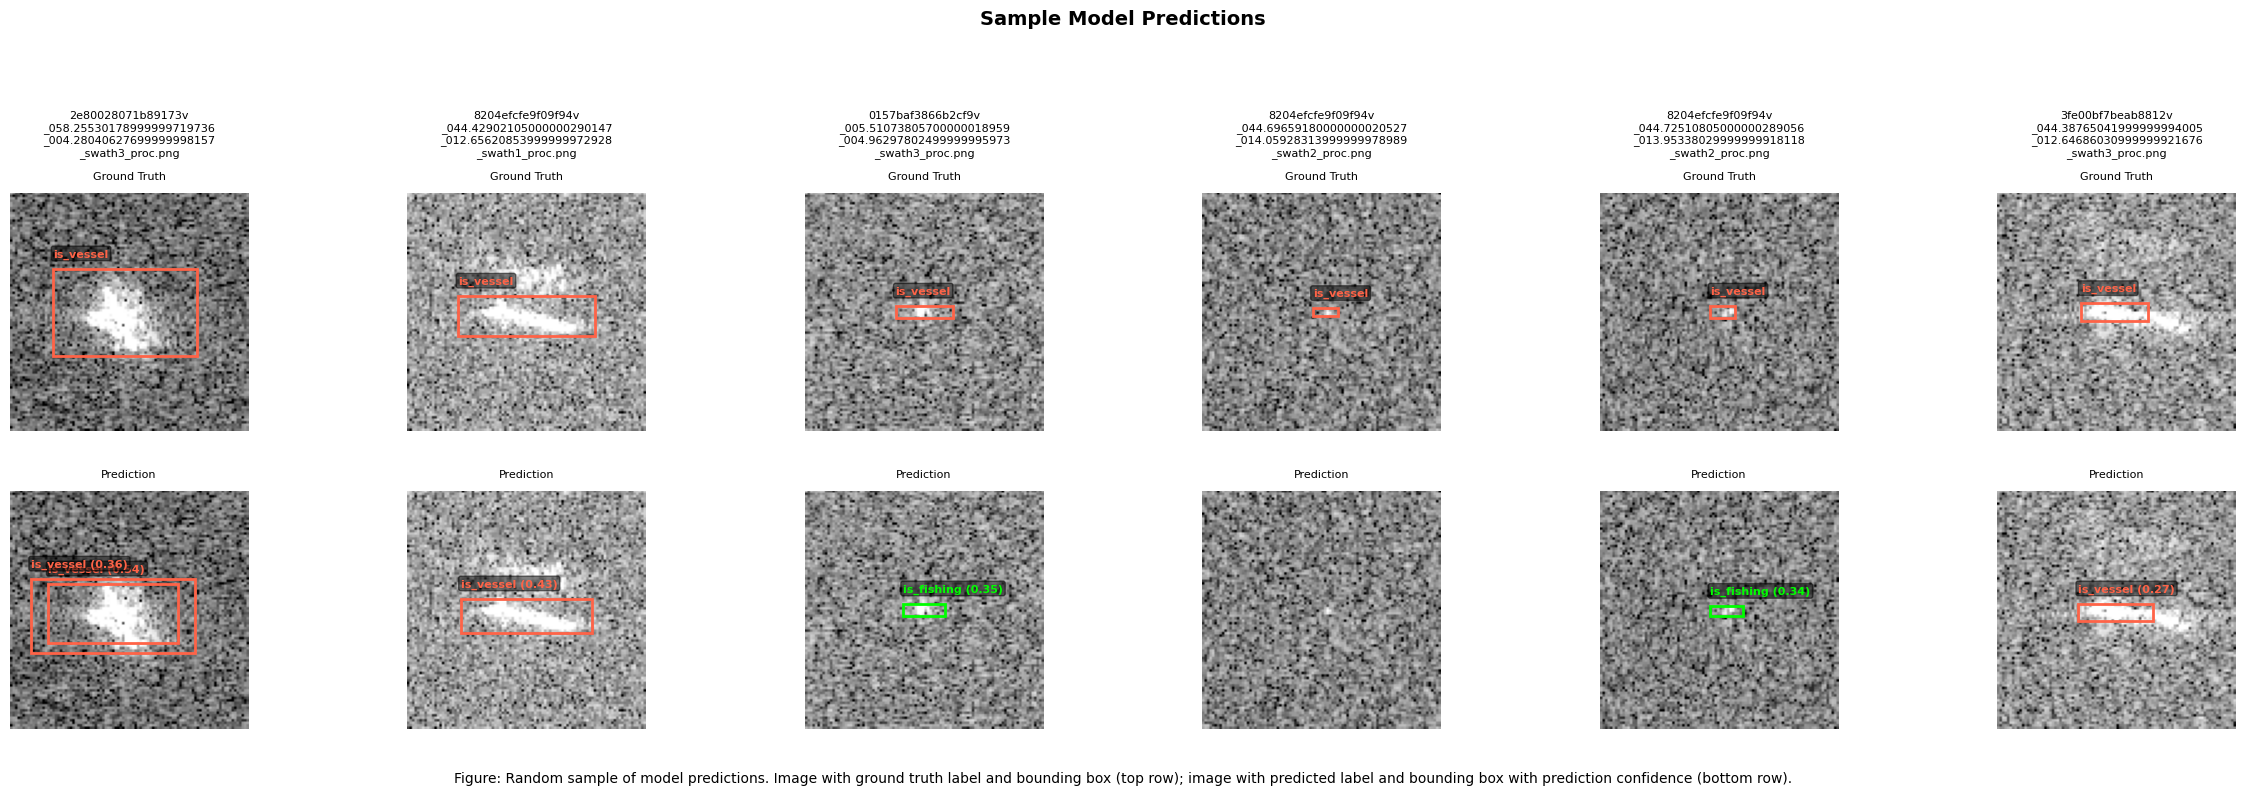

In [21]:
# Randomely select six test images to display
model = YOLO(model_path)
create_sar_prediction_comparison(model, test_images_path, num_images=6)